In [9]:
!pip install catboost

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor

In [11]:
#Все значения принимаются и выводятся в СИ

In [38]:
def physics_model(v0, angle, C_d, mass, A=0.01, dt=0.01):
  '''
  physics_model(v0[m/s], angle[degree], C_d, mass[kg], A=0.01, dt=0.01[s])
  Функция physics_model получает значения v0(начальной скорости),
  angle(угла наклона), C_d(коэф сопротивления), mass(массы).
  С помощью уравнений Эйлера находит траекторию полета объекта.
  Возвращает массив trajectory с координатами x,y.
  '''
  import numpy as np
  angle_rad = np.radians(angle)
  g = 9.80665 #Ускорение свободного падения [m/s**2]
  rho = 1.225 #Плотность воздуха [kg/m**3]
  vx = v0 * np.cos(angle_rad) #Проекция скорости тела на ось X
  vy = v0 * np.sin(angle_rad) #Проекция скорости тела на ось Y
  x, y = 0, 0 #Координата тела по оси X и Y
  trajectory = [[0,0]]
  while y >= 0:
      v = np.sqrt(vx**2 + vy**2) #Общий вектор скорости
      F_drag = 0.5 * rho * C_d * A * v**2 #Сила лобового сопротивления
      ax = -(F_drag / mass) * (vx / v) #Ускорение по оси X
      ay = -g - (F_drag / mass) * (vy / v) #Ускорение по оси Y
      #Изменение скорости за промежуток dt
      vx += ax * dt
      vy += ay * dt
      #Изменение координаты за промежуток dt
      if (vy * dt + y) >= 0:
        x += vx * dt
        y += vy * dt
      else:
        y = 0
        break
      trajectory.append([x, y])
  return np.array(trajectory)

In [13]:
def hybrid_predict(v0, angle, mass, C_d, wind):
  """
  hybrid_predict(v0[m/s], angle[degree], mass[kg], C_d, wind[m/s])
  Функция получает значения v0(начальной скорости),
  angle(угла наклона), C_d(коэф сопротивления), mass(массы),
  wind(ветра).
  Находит ошибку в дальности полета согласно модели и корректирует
  Возвращает скорректированную дальность полета x_hybrid,
  траекторию физ. модели physics_traj
  """
  physics_traj = physics_model(v0, angle, C_d, mass)
  x_physics = physics_traj[-1, 0] #Конечная точка полета

  input_features = [[v0, angle, mass, C_d, wind, x_physics]]
  error = model.predict(input_features)[0]

  x_hybrid = x_physics + error #Создание гибридной конечной точки
  return x_hybrid, physics_traj

In [14]:
#Обрабатывание датасета
df = pd.read_csv('ballistic_dataset.csv')
df['error'] = df['x_real'] - df['x_physics']
X = df[['v0', 'angle', 'C_d', 'mass', 'wind', 'x_physics']]
Y = df['error']

In [15]:
#Обучение модели
model = CatBoostRegressor(iterations=500, learning_rate=0.05, verbose=100)
model.fit(X, Y)

0:	learn: 1.6665324	total: 50ms	remaining: 24.9s
100:	learn: 0.3297536	total: 445ms	remaining: 1.76s
200:	learn: 0.2242825	total: 946ms	remaining: 1.41s
300:	learn: 0.1789777	total: 1.45s	remaining: 961ms
400:	learn: 0.1531173	total: 2.29s	remaining: 566ms
499:	learn: 0.1354865	total: 2.93s	remaining: 0us


In [43]:
#Получение искомых значений
x_hybrid, physics_traj = hybrid_predict \
 (v0=5, angle=45, mass=10.0, C_d=0.2, wind=1.0)

In [32]:
physics_traj[0]

array([0.03535317, 0.03437251])

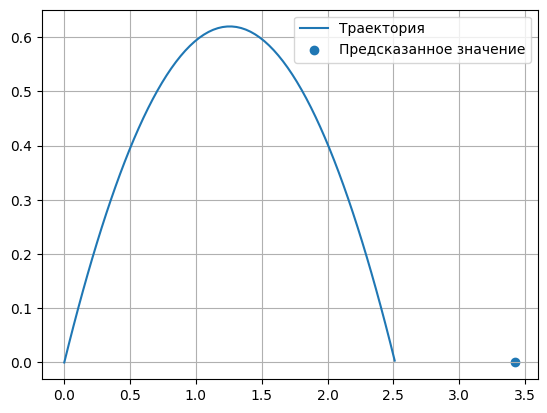

In [47]:
#Создание графика полета
plt.plot(physics_traj[:, 0], physics_traj[:, 1], label='Траектория')
plt.scatter(x_hybrid, 0, label='Предсказанное значение')
plt.grid()
plt.legend()